In [3]:
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
v = pd.read_csv('hits_and_tracks_3d_events_all.csv', sep=';')
print("features data loaded...")

features data loaded...


In [6]:
#Prepare a set of X data
Xs=[]
#Length of a graph
cut=4
#Number of training samples
n_samples=10
for i in range(n_samples):
    #Focus on event_id=i
    rows_with_event_id_zero = v[v['event_id'] == i]
    #Extract coordinates and label with hit_id in time-order
    new_df=rows_with_event_id_zero[['hit_id','hit_r','hit_theta','hit_z']]
    new_df.set_index('hit_id',inplace=True)
    #Convert to x, y, z coordinates
    new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
    new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
    new_df=new_df[['hit_x','hit_y','hit_z']]
    # Flatten data
    raw_data=new_df[:cut].values
    X=raw_data.flatten()
    Xs.append(X)

<ipython-input-6-cb57288c16df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
<ipython-input-6-cb57288c16df>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
<ipython-input-6-cb57288c16df>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [13]:
#Define Ys
Ys = []
Ys_01 = []
#Regularization for binary loss
epsilon=0.01
#Number of vertices in each sample
cut=4
for i in range(n_samples):
    Y = np.array([0.01,0.99,0.99,0.99])  # True edge labels of dimension
    Ys_01.append([0.01,0.99,0.99,0.99])
    Ys.append(Y)
print("Ys prepared...")

Ys prepared...


In [14]:
print("Xs shape ",len(Xs),len(Xs[0]))
print("Ys shape ",len(Ys),len(Ys[0]))

Xs shape  10 12
Ys shape  10 4


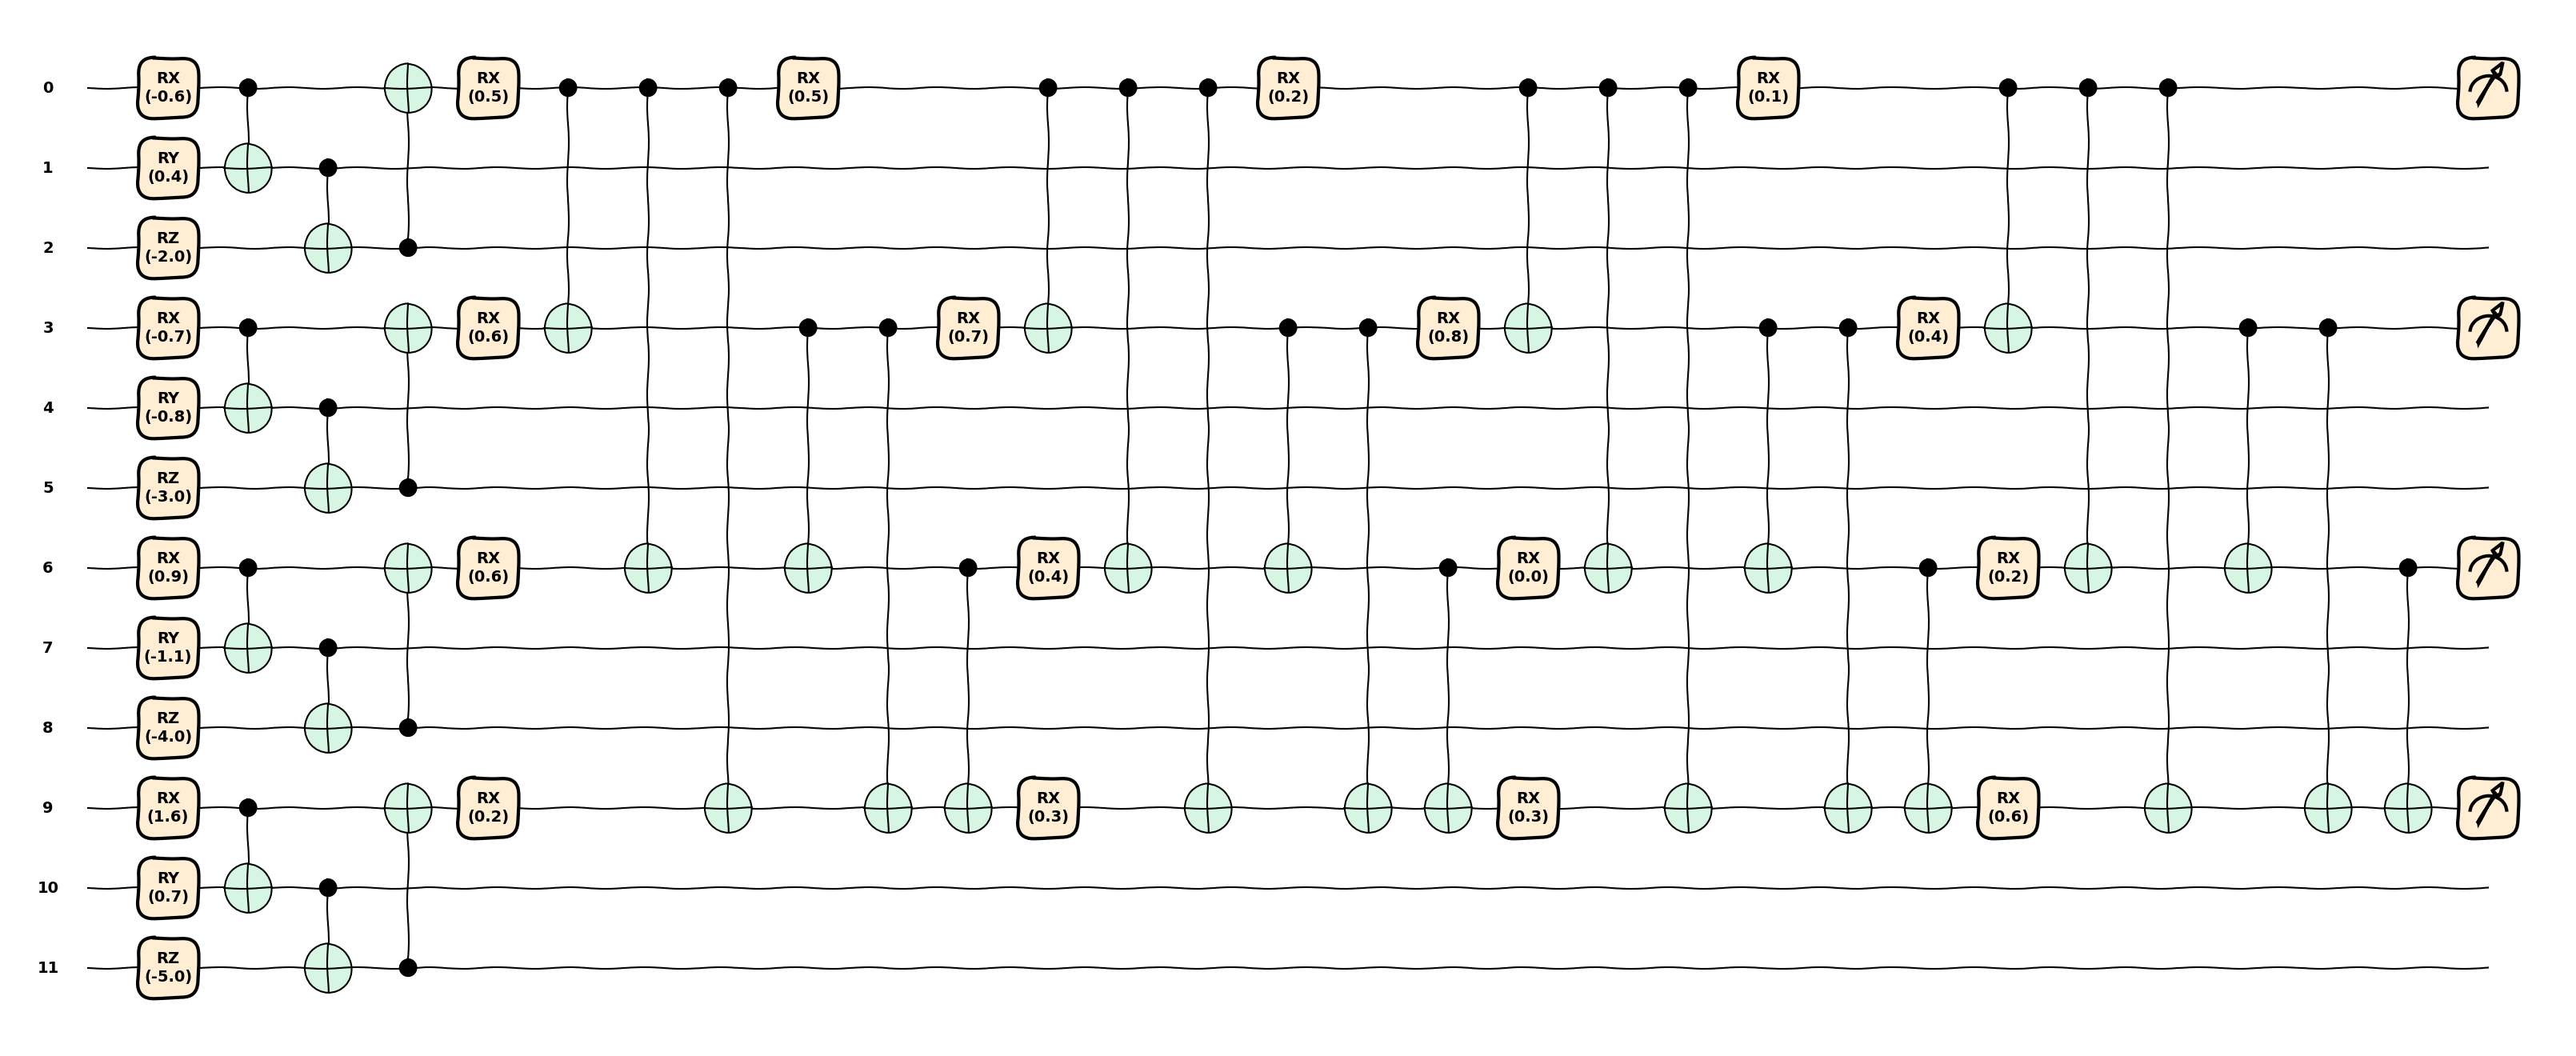

In [15]:
# Create a quantum circuit with Nv qubits
import pennylane as qml
from qiskit.circuit import Parameter
#Number of nodes
Nv = cut
#Number of qubits
num_qubits = Nv * 3  # 3 qubits per row (x,y,z,color)
# Define a list of trainable parameters for the entanglement
num_params = cut  # Number of trainable parameters for the entanglement
layers=4
ansatz = np.random.random(size=(num_params*layers))
def quantum_circuit(X,ansatz):
    for i in range(Nv):
        for j in range(3):
            if j==0:
                qml.RX(X[i*3+j], wires = i * 3 + j)
            elif j==1:
                qml.RY(X[i*3+j], wires = i * 3 + j)
            else:
                qml.RZ(X[i*3+j], wires = i * 3 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 3, i * 3 + 1])
        qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
        qml.CNOT(wires = [i * 3 + 2, i * 3])
    for l in range(layers):
        # Apply trainable gates
        for i in range(cut):
            qml.RX(ansatz[i+l*cut], wires = i * 3)
        #Fully connect
        for i in range(cut):
            for j in range(i + 1, cut):
                # Use trainable parameters for entanglement angles
                qml.CNOT(wires = [i * 3, j * 3])
    return [qml.expval(qml.PauliZ(i*3)) for i in range(Nv)]

dev = qml.device("default.qubit", wires=3*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [17]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*3)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(3):
                if j==0:
                    qml.RX(X[i*3+j], wires = i * 3 + j)
                elif j==1:
                    qml.RY(X[i*3+j], wires = i * 3 + j)
                else:
                    qml.RZ(X[i*3+j], wires = i * 3 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 3, i * 3 + 1])
            qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
            qml.CNOT(wires = [i * 3 + 2, i * 3])
        for l in range(layers):
            # Apply trainable gates
            for i in range(cut):
                qml.RX(ansatz[i+l*cut], wires = i * 3)
            #Fully connect
            for i in range(cut):
                for j in range(i + 1, cut):
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 3, j * 3])
        return [qml.expval(qml.PauliZ(i*3)) for i in range(Nv)]
    expectations = quantum_circuit(X, ansatz)
    return expectations
Adj=[[0,1,0,0],[0,0,1,0],[0,0,0,1],[0,0,0,0]]
#Binary entropy loss function
def binary(x,xp):
    new_x=[0 for _ in range(len(xp))]
    l=0
    for i in range(Nv):
        for j in range(i+1,Nv):
            if Adj[i][j]==1:
                new_x[l]=x[i]+x[j]
                l+=1
    res=[x[i]*np.log(1-xp[i])+(1-x[i])*np.log(xp[i])
        for i in range(len(x)-1)]
    return -(1/(len(x)-1))*sum(res)
def costfunc(params):
    cost = 0
    for i in range(n_samples):
        cost += binary(circuit(Xs[i], params),Ys[i])
    return cost/n_samples
from pennylane import numpy as np
#Initialize trainable parameters
ansatz = np.random.normal(0, 0.1, size=(num_params*layers), requires_grad=True)
#Set-up the optimizer
optimizer = qml.AdamOptimizer(stepsize=0.01)
previous_cost = float('inf')  # Set to a large initial value
# A small threshold to check for convergence
tolerance = 1e-4
#Training start
for k in range(30):
    cost=costfunc(ansatz)
    if k % 3 == 0:
        print(f"Step {k}, cost: {cost}")
    if abs(cost - previous_cost) < tolerance:
        print(f"Converged at step {k}, cost: {cost}")
        break
    ansatz = optimizer.step(costfunc, ansatz)
    previous_cost=cost

Step 0, cost: 2.5578834764002605
Step 3, cost: 2.501365989988492
Step 6, cost: 2.431886896250122
Step 9, cost: 2.34988368604094
Step 12, cost: 2.255933558570243
Step 15, cost: 2.1509755719294743
Step 18, cost: 2.0366954310894974
Step 21, cost: 1.9157257474308929
Step 24, cost: 1.7914290492092917
Step 27, cost: 1.667478787162929


In [18]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*4)
@qml.qnode(dev)
def measure(X,ansatz):
    expect = quantum_circuit(X,ansatz)
    return expect
def zeroOne(arr):
    return [1 if n>0.5 else 0 for n in arr]
for i in range(n_samples):
    result=measure(Xs[i],ansatz)
    print("Compare ",result,
          " with ",Ys_01[i])

Compare  [tensor(0.84137563, requires_grad=True), tensor(0.399166, requires_grad=True), tensor(0.18812137, requires_grad=True), tensor(0.35090354, requires_grad=True)]  with  [0.01, 0.99, 0.99, 0.99]
Compare  [tensor(0.91495909, requires_grad=True), tensor(0.56862405, requires_grad=True), tensor(0.40270494, requires_grad=True), tensor(0.34434155, requires_grad=True)]  with  [0.01, 0.99, 0.99, 0.99]
Compare  [tensor(0.73601392, requires_grad=True), tensor(0.22599949, requires_grad=True), tensor(0.44923099, requires_grad=True), tensor(-0.18052822, requires_grad=True)]  with  [0.01, 0.99, 0.99, 0.99]
Compare  [tensor(0.6575557, requires_grad=True), tensor(0.27707442, requires_grad=True), tensor(0.2564239, requires_grad=True), tensor(0.46661746, requires_grad=True)]  with  [0.01, 0.99, 0.99, 0.99]
Compare  [tensor(0.90115665, requires_grad=True), tensor(0.57332026, requires_grad=True), tensor(0.44657974, requires_grad=True), tensor(0.43478299, requires_grad=True)]  with  [0.01, 0.99, 0.99,